# KNN Model(Binary) for MIT data 
As we concluded before, for MIT data, we apply the following preprocessing:   
resampling: Oversampling
rescaling: MinMax Scaler

If you don't have the original files: run the notebook `preprocessing_mit_binary_shift_minmax_oversampling.ipynb`       

Input file: (The preprocessed data)   
mitbih_binary_train_shift_minmax_oversampling.csv
mitbih_binary_test_shift_minmax_oversampling.csv

Output: KNN model trained  
model_mit_binary_shift_knn.pkl

In [6]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


## Read data 


In [7]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for oversampling
import matplotlib.pyplot as plt
import seaborn as sns


RawFiles = dict({
    'train': data_path + 'mitbih_binary_train_shift_minmax_oversampling.csv', 
    'test': data_path + 'mitbih_binary_test_shift_minmax_oversampling.csv'  
})

OutputFiles = dict({
    'model': model_output_path +  'model_mit_binary_shift_knn.pkl',
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



# Grid Search for optimized KNN with MinMax Scaler

Fitting 3 folds for each of 3 candidates, totalling 9 fits
KNN Best parameters: {'model__algorithm': 'auto', 'model__n_neighbors': 5, 'model__weights': 'distance'}
KNN Best score: 0.9825315730645964
KNN F1 score: 0.854585152838428


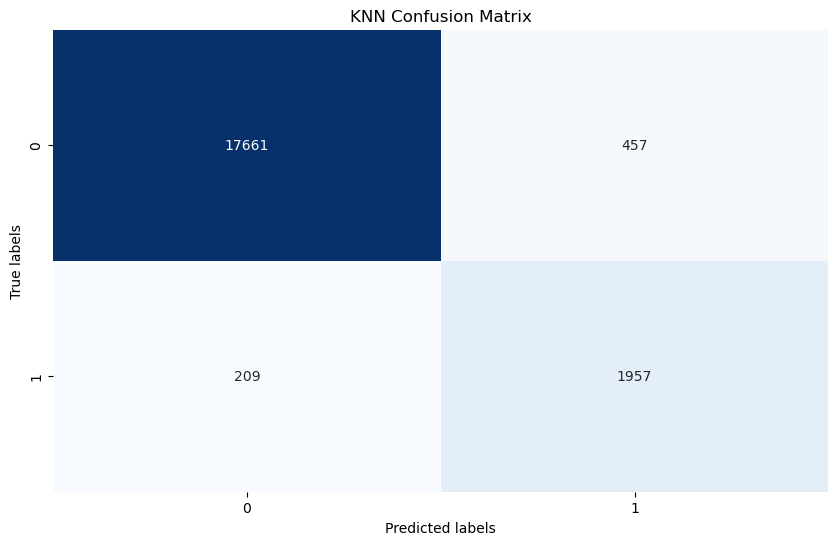

KNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     18118
         1.0       0.81      0.90      0.85      2166

    accuracy                           0.97     20284
   macro avg       0.90      0.94      0.92     20284
weighted avg       0.97      0.97      0.97     20284



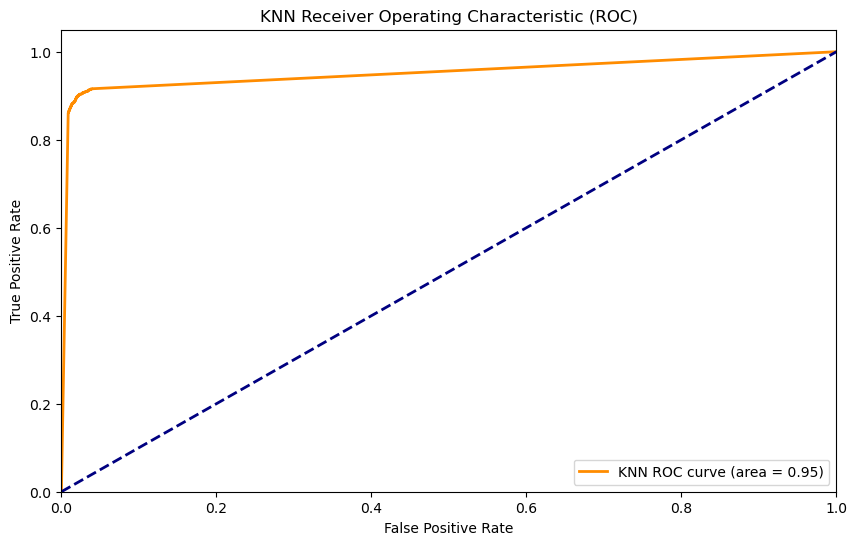

In [8]:
# Define KNN model
knn_model = KNeighborsClassifier()

# Grid parameters for KNN
knn_grid_params = {
    'model__n_neighbors': [5, 7, 10],  # Number of neighbors to use for kneighbors queries
    'model__weights': ['distance'],  # Weight function used in prediction
    'model__algorithm': ['auto'] # Algorithm to compute nearest neighbors
}

# Create a pipeline that includes scaling, oversampling, and KNN
pipeline = ImbPipeline([
    ('model', knn_model)  # KNN model
])

# Initialize GridSearchCV
knn_grid_search = GridSearchCV(pipeline, knn_grid_params, cv=3, n_jobs=-1, verbose=1, scoring='f1')

try:
    # Fit the KNN grid search on the training data
    knn_grid_search.fit(X_train, y_train)
    
    # Get the best parameters and model for KNN
    knn_best_params = knn_grid_search.best_params_
    print("KNN Best parameters:", knn_best_params)

    knn_best_score = knn_grid_search.best_score_
    print("KNN Best score:", knn_best_score)

    knn_best_model = knn_grid_search.best_estimator_

    # Predict and evaluate KNN on test data using the pipeline
    y_pred_knn = knn_best_model.predict(X_test)
    f1_knn = f1_score(y_test, y_pred_knn)
    print("KNN F1 score:", f1_knn)

    # Generate and plot confusion matrix
    conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
    plt.figure(figsize=(10, 6))
    sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('KNN Confusion Matrix')
    plt.show()

    # Generate and print classification report
    class_report_knn = classification_report(y_test, y_pred_knn)
    print("KNN Classification Report:\n", class_report_knn)

    # ROC curve and AUC for classification
    if len(np.unique(y_test)) == 2: # Only applicable for binary classification
        y_prob_knn = knn_best_model.predict_proba(X_test)[:, 1]
        fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
        roc_auc_knn = auc(fpr_knn, tpr_knn)

        plt.figure(figsize=(10, 6))
        plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='KNN ROC curve (area = %0.2f)' % roc_auc_knn)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('KNN Receiver Operating Characteristic (ROC)')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("ROC curve is only applicable for binary classification in KNN.")
    
except ValueError as e:
    print(f"Error during GridSearchCV: {e}")


# Save Best KNN Model

In [9]:
# Save model 
import pickle
# Save the model to a file
with open(OutputFiles.get('model'), 'wb') as model_file: #wb means writing the file in binary mode
    pickle.dump(knn_best_model, model_file)

In [10]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-12-10 14:10:20.522917
